In [1]:

import gdown
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [ ]:
df = "augmentated_dataset_2/augmented_dataset_info.csv"

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

BATCH_SIZE = 64
IMG_SIZE = (256, 256)
DATA_DIR = "augmented_dataset_2"
SEED = 123

full_ds = image_dataset_from_directory(
    DATA_DIR,
    seed=SEED,
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

dataset_size = full_ds.cardinality().numpy()
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

class_names = full_ds.class_names
print("Label:", class_names)


Found 39499 files belonging to 5 classes.
Label: ['0', '1', '2', '3', '4']


In [47]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


base_model = MobileNetV2(input_shape=(256, 256, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = True


fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = models.Sequential([
    layers.Lambda(preprocess_input, input_shape=(256, 256, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(5, activation='softmax') 
])

C:\Users\cahya\AppData\Local\Temp\ipykernel_7000\940280281.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(256, 256, 3),


In [49]:
# Compile model dengan learning rate kecil
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_4 (Lambda)               │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,620,997 (10.00 MB)

 Trainable params: 2,223,685 (8.48 MB)

 Non-trainable params: 397,312 (1.52 MB)

In [50]:
# Callbacks
checkpoint_cb = ModelCheckpoint(
    'best_model2.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)


In [51]:
labels = df['label'].astype(int)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.9703703703703703), 1: np.float64(1.0076923076923077), 2: np.float64(1.0076923076923077), 3: np.float64(1.0076923076923077), 4: np.float64(1.0076923076923077)}


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint_cb, lr_scheduler]
)

Epoch 1/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2565 - loss: 2.4470
Epoch 1: val_loss improved from inf to 1.59491, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 856s 2s/step - accuracy: 0.2566 - loss: 2.4466 - val_accuracy: 0.4234 - val_loss: 1.5949 - learning_rate: 1.0000e-05
Epoch 2/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3978 - loss: 1.8796
Epoch 2: val_loss improved from 1.59491 to 1.40191, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 835s 2s/step - accuracy: 0.3979 - loss: 1.8794 - val_accuracy: 0.5074 - val_loss: 1.4019 - learning_rate: 1.0000e-05
Epoch 3/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4721 - loss: 1.6453
Epoch 3: val_loss improved from 1.40191 to 1.26854, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 835s 2s/step - accuracy: 0.4721 - loss: 1.6452 - val_accuracy: 0.5569 - val_loss: 1.2685 - learning_rate: 1.0000e-05
Epoch 4/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5095 - loss: 1.4786
Epoch 4: val_loss improved from 1.26854 to 1.15520, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 837s 2s/step - accuracy: 0.5096 - loss: 1.4785 - val_accuracy: 0.5969 - val_loss: 1.1552 - learning_rate: 1.0000e-05
Epoch 5/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5438 - loss: 1.3722
Epoch 5: val_loss improved from 1.15520 to 1.08630, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 835s 2s/step - accuracy: 0.5438 - loss: 1.3722 - val_accuracy: 0.6293 - val_loss: 1.0863 - learning_rate: 1.0000e-05
Epoch 6/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5652 - loss: 1.3000
Epoch 6: val_loss improved from 1.08630 to 1.02412, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 836s 2s/step - accuracy: 0.5652 - loss: 1.3000 - val_accuracy: 0.6496 - val_loss: 1.0241 - learning_rate: 1.0000e-05
Epoch 7/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5798 - loss: 1.2485
Epoch 7: val_loss improved from 1.02412 to 0.95613, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 835s 2s/step - accuracy: 0.5798 - loss: 1.2485 - val_accuracy: 0.6700 - val_loss: 0.9561 - learning_rate: 1.0000e-05
Epoch 8/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6022 - loss: 1.1829
Epoch 8: val_loss improved from 0.95613 to 0.89654, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 851s 2s/step - accuracy: 0.6022 - loss: 1.1828 - val_accuracy: 0.6856 - val_loss: 0.8965 - learning_rate: 1.0000e-05
Epoch 9/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6230 - loss: 1.1131
Epoch 9: val_loss improved from 0.89654 to 0.86723, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 847s 2s/step - accuracy: 0.6230 - loss: 1.1131 - val_accuracy: 0.6961 - val_loss: 0.8672 - learning_rate: 1.0000e-05
Epoch 10/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6372 - loss: 1.0651
Epoch 10: val_loss improved from 0.86723 to 0.84443, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 835s 2s/step - accuracy: 0.6372 - loss: 1.0652 - val_accuracy: 0.7017 - val_loss: 0.8444 - learning_rate: 1.0000e-05
Epoch 11/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6531 - loss: 1.0213
Epoch 11: val_loss improved from 0.84443 to 0.83193, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 837s 2s/step - accuracy: 0.6531 - loss: 1.0214 - val_accuracy: 0.7090 - val_loss: 0.8319 - learning_rate: 1.0000e-05
Epoch 12/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6599 - loss: 0.9860
Epoch 12: val_loss improved from 0.83193 to 0.80275, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 847s 2s/step - accuracy: 0.6598 - loss: 0.9860 - val_accuracy: 0.7179 - val_loss: 0.8027 - learning_rate: 1.0000e-05
Epoch 13/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6646 - loss: 0.9531
Epoch 13: val_loss improved from 0.80275 to 0.78898, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 838s 2s/step - accuracy: 0.6646 - loss: 0.9531 - val_accuracy: 0.7248 - val_loss: 0.7890 - learning_rate: 1.0000e-05
Epoch 14/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6803 - loss: 0.9046
Epoch 14: val_loss improved from 0.78898 to 0.77940, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 837s 2s/step - accuracy: 0.6803 - loss: 0.9047 - val_accuracy: 0.7287 - val_loss: 0.7794 - learning_rate: 1.0000e-05
Epoch 15/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6830 - loss: 0.8832
Epoch 15: val_loss improved from 0.77940 to 0.76148, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 837s 2s/step - accuracy: 0.6830 - loss: 0.8832 - val_accuracy: 0.7336 - val_loss: 0.7615 - learning_rate: 1.0000e-05
Epoch 16/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6926 - loss: 0.8453
Epoch 16: val_loss improved from 0.76148 to 0.75468, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 836s 2s/step - accuracy: 0.6926 - loss: 0.8453 - val_accuracy: 0.7348 - val_loss: 0.7547 - learning_rate: 1.0000e-05
Epoch 17/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7077 - loss: 0.8157
Epoch 17: val_loss improved from 0.75468 to 0.73820, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 838s 2s/step - accuracy: 0.7077 - loss: 0.8157 - val_accuracy: 0.7421 - val_loss: 0.7382 - learning_rate: 1.0000e-05
Epoch 18/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7133 - loss: 0.7910
Epoch 18: val_loss improved from 0.73820 to 0.73232, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 839s 2s/step - accuracy: 0.7133 - loss: 0.7910 - val_accuracy: 0.7450 - val_loss: 0.7323 - learning_rate: 1.0000e-05
Epoch 19/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7252 - loss: 0.7664
Epoch 19: val_loss improved from 0.73232 to 0.72029, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 836s 2s/step - accuracy: 0.7252 - loss: 0.7664 - val_accuracy: 0.7564 - val_loss: 0.7203 - learning_rate: 1.0000e-05
Epoch 20/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7322 - loss: 0.7378
Epoch 20: val_loss improved from 0.72029 to 0.71874, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 838s 2s/step - accuracy: 0.7322 - loss: 0.7378 - val_accuracy: 0.7527 - val_loss: 0.7187 - learning_rate: 1.0000e-05
Epoch 21/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7423 - loss: 0.7150
Epoch 21: val_loss improved from 0.71874 to 0.69373, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 838s 2s/step - accuracy: 0.7423 - loss: 0.7150 - val_accuracy: 0.7581 - val_loss: 0.6937 - learning_rate: 1.0000e-05
Epoch 22/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7524 - loss: 0.6751
Epoch 22: val_loss improved from 0.69373 to 0.68356, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 838s 2s/step - accuracy: 0.7524 - loss: 0.6751 - val_accuracy: 0.7637 - val_loss: 0.6836 - learning_rate: 1.0000e-05
Epoch 23/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7579 - loss: 0.6532
Epoch 23: val_loss improved from 0.68356 to 0.67505, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 839s 2s/step - accuracy: 0.7579 - loss: 0.6532 - val_accuracy: 0.7644 - val_loss: 0.6750 - learning_rate: 1.0000e-05
Epoch 24/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7683 - loss: 0.6273
Epoch 24: val_loss did not improve from 0.67505
432/432 ━━━━━━━━━━━━━━━━━━━━ 831s 2s/step - accuracy: 0.7683 - loss: 0.6273 - val_accuracy: 0.7649 - val_loss: 0.6782 - learning_rate: 1.0000e-05
Epoch 25/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7818 - loss: 0.5992
Epoch 25: val_loss improved from 0.67505 to 0.67128, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 832s 2s/step - accuracy: 0.7818 - loss: 0.5992 - val_accuracy: 0.7661 - val_loss: 0.6713 - learning_rate: 1.0000e-05
Epoch 26/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7906 - loss: 0.5732
Epoch 26: val_loss improved from 0.67128 to 0.66419, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 832s 2s/step - accuracy: 0.7906 - loss: 0.5732 - val_accuracy: 0.7718 - val_loss: 0.6642 - learning_rate: 1.0000e-05
Epoch 27/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8045 - loss: 0.5425
Epoch 27: val_loss improved from 0.66419 to 0.65656, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 833s 2s/step - accuracy: 0.8045 - loss: 0.5425 - val_accuracy: 0.7698 - val_loss: 0.6566 - learning_rate: 1.0000e-05
Epoch 28/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8056 - loss: 0.5277
Epoch 28: val_loss did not improve from 0.65656
432/432 ━━━━━━━━━━━━━━━━━━━━ 832s 2s/step - accuracy: 0.8056 - loss: 0.5277 - val_accuracy: 0.7665 - val_loss: 0.6709 - learning_rate: 1.0000e-05
Epoch 29/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8148 - loss: 0.5011
Epoch 29: val_loss improved from 0.65656 to 0.64951, saving model to best_model2.h5


432/432 ━━━━━━━━━━━━━━━━━━━━ 833s 2s/step - accuracy: 0.8148 - loss: 0.5011 - val_accuracy: 0.7781 - val_loss: 0.6495 - learning_rate: 1.0000e-05
Epoch 30/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8213 - loss: 0.4876
Epoch 30: val_loss did not improve from 0.64951
432/432 ━━━━━━━━━━━━━━━━━━━━ 832s 2s/step - accuracy: 0.8213 - loss: 0.4876 - val_accuracy: 0.7744 - val_loss: 0.6524 - learning_rate: 1.0000e-05
Epoch 31/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8374 - loss: 0.4479
Epoch 31: val_loss did not improve from 0.64951

Epoch 31: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
432/432 ━━━━━━━━━━━━━━━━━━━━ 831s 2s/step - accuracy: 0.8374 - loss: 0.4479 - val_accuracy: 0.7688 - val_loss: 0.6584 - learning_rate: 1.0000e-05
Epoch 32/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8344 - loss: 0.4503
Epoch 32: val_loss did not improve from 0.64951
432/432 ━━━━━━━━━━━━━━━━━━━━ 832s 2s/step - accuracy: 0.8344 - loss: 0.4503 - v

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Ambil semua data dan label dari test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 431ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 432ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 431ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 438ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 432ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 430ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

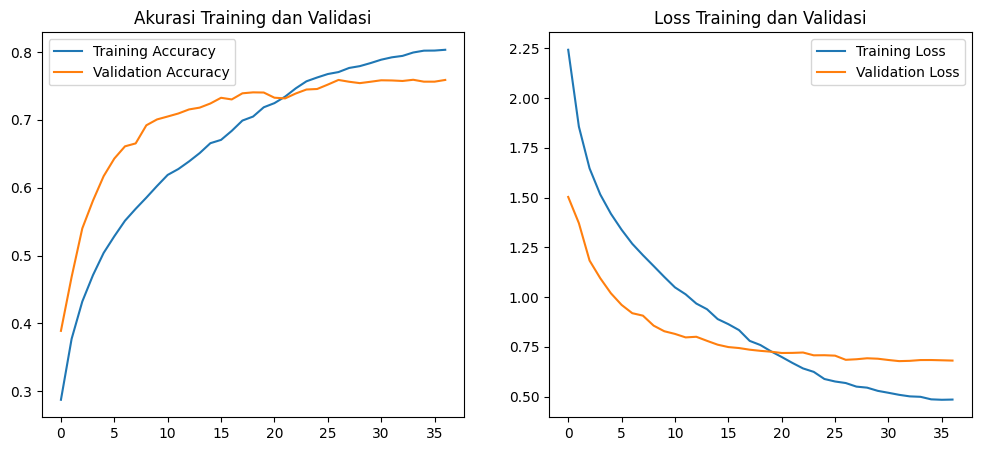

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Akurasi Training dan Validasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss Training dan Validasi')
plt.legend()

plt.show()

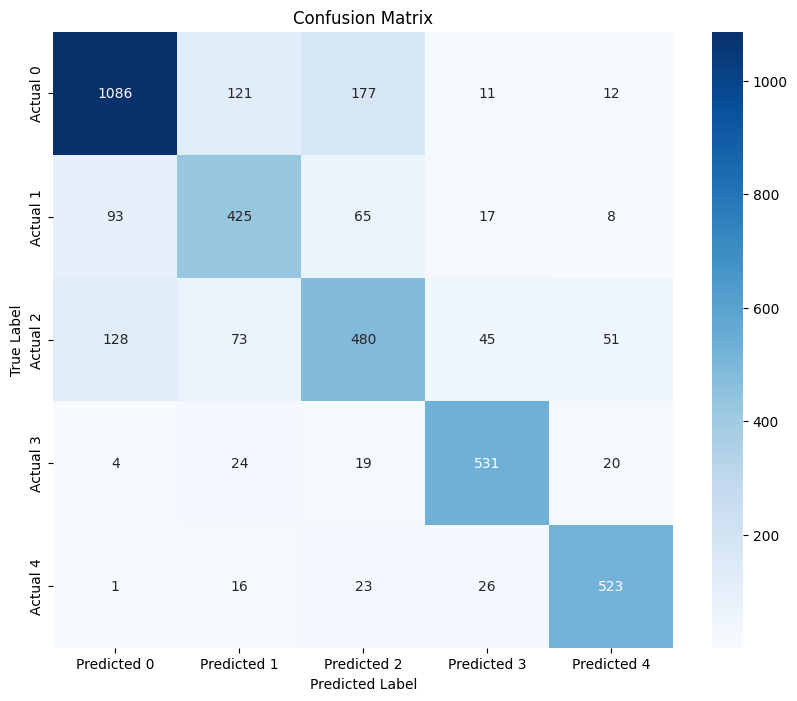

Classification Report:

              precision    recall  f1-score   support

           0     0.8277    0.7719    0.7988      1407
           1     0.6449    0.6990    0.6709       608
           2     0.6283    0.6178    0.6230       777
           3     0.8429    0.8880    0.8648       598
           4     0.8518    0.8879    0.8695       589

    accuracy                         0.7653      3979
   macro avg     0.7591    0.7729    0.7654      3979
weighted avg     0.7667    0.7653    0.7653      3979



In [32]:
from sklearn.metrics import confusion_matrix


cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4]),
    index=[f"Actual {name}" for name in class_names],
    columns=[f"Predicted {name}" for name in class_names]
)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


In [ ]:
from tensorflow.keras.preprocessing import image

img_path = 'train/10_left.jpeg'

img = image.load_img(img_path, target_size=(256, 256))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted class: 0


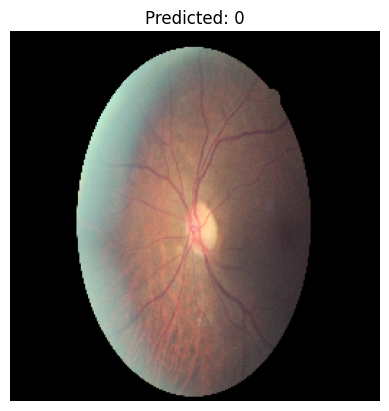

In [ ]:

pred = model.predict(img_array)
predicted_class = np.argmax(pred)

# Menampilkan hasil
print(f"Predicted class: {predicted_class}")


plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()



In [74]:
print(f"Predicted class: {class_names[predicted_class]}")


Predicted class: 0


In [55]:
model.save('my_model.keras')

